In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import glob

# Experiment 6 - Iris Segmentation

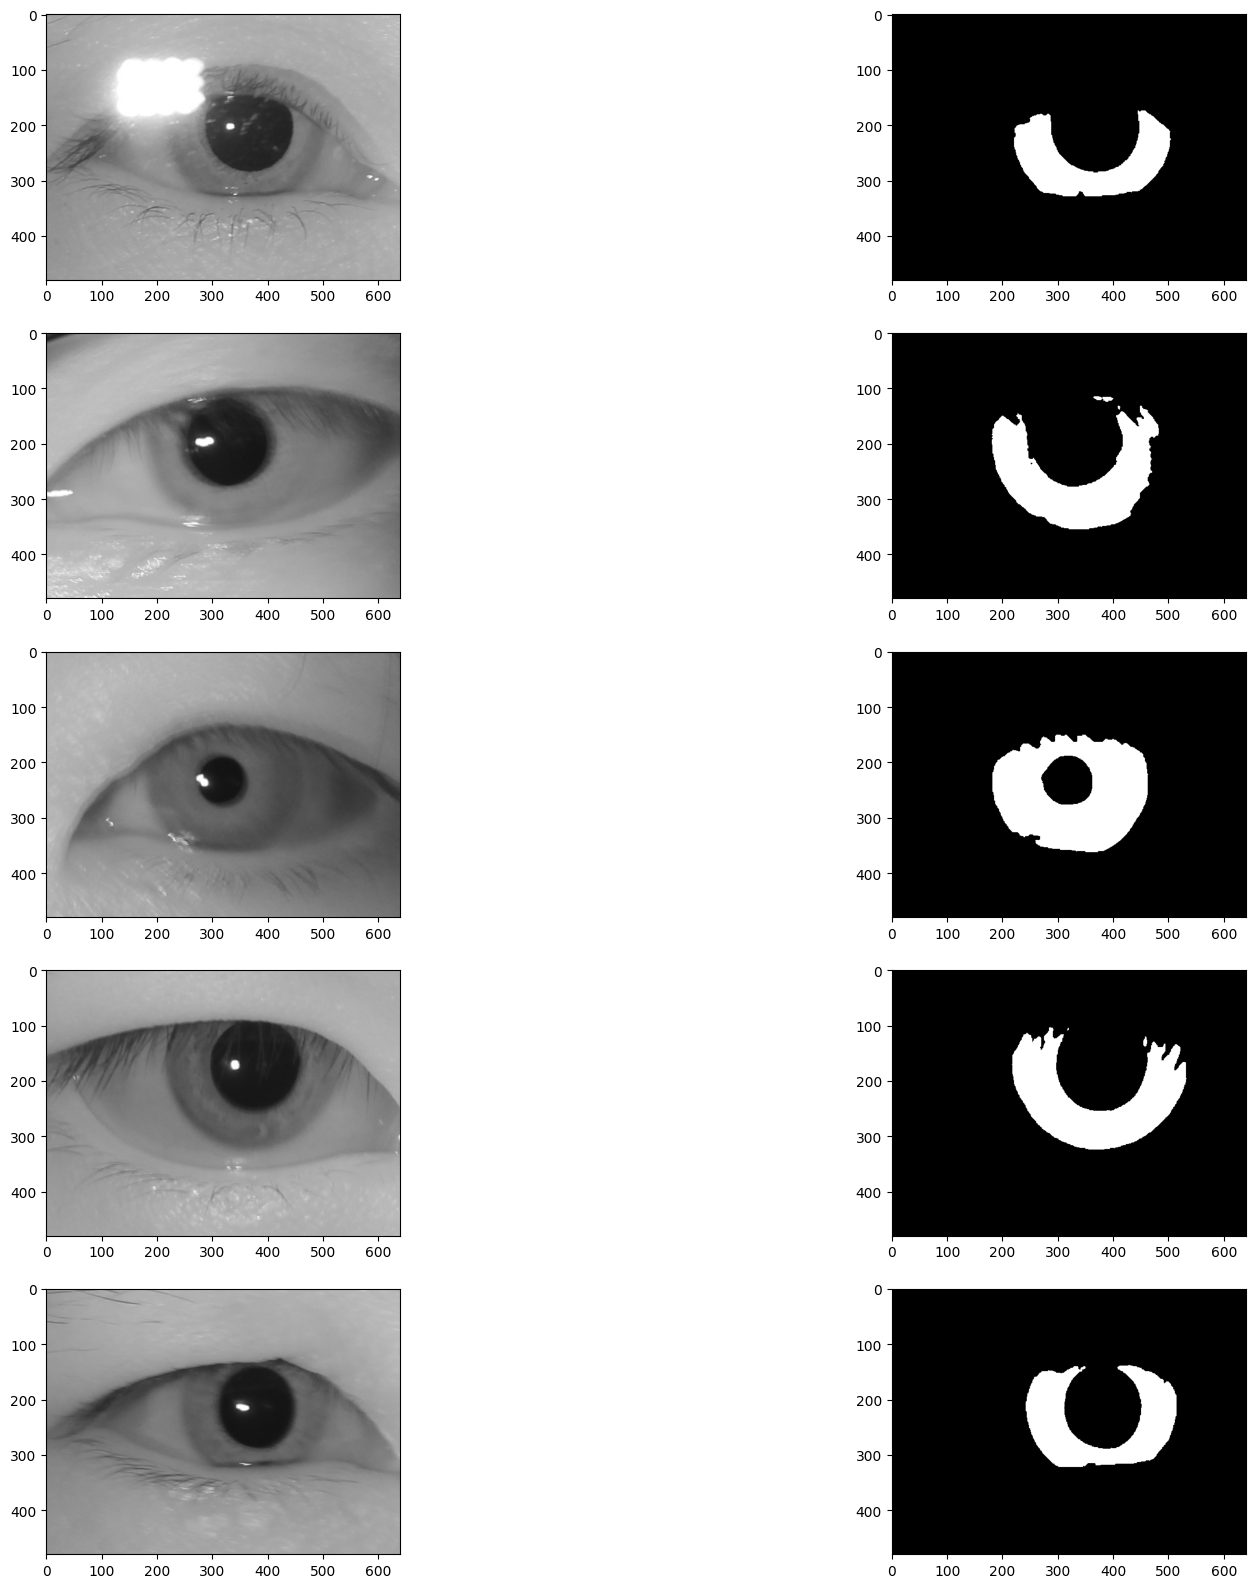

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

FOLDER_LOCATION = '/kaggle/input/casia-iris-degradation/CASIA-Iris-Degradation-Database/'
NO_OF_IMAGE = 5

image_list = []
mask_list = []
for i in range(NO_OF_IMAGE):
    file = random.choice(os.listdir(os.path.join(FOLDER_LOCATION, 'image/')))
    image = cv2.imread(os.path.join(os.path.join(FOLDER_LOCATION, 'image/'),file))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_list.append(image)

    mask = cv2.imread(os.path.join(os.path.join(FOLDER_LOCATION, 'segmentaion mask/'),file))
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    mask_list.append(mask)

image_list = np.array(image_list)
mask_list = np.array(mask_list)

fig, ax = plt.subplots(NO_OF_IMAGE, 2,figsize=(20,20))
for i in range(NO_OF_IMAGE):
    ax[i][0].imshow(image_list[i], cmap='gray')
    ax[i][1].imshow(mask_list[i], cmap='gray')

plt.show()

# Experiment 7 - Iris Normalization

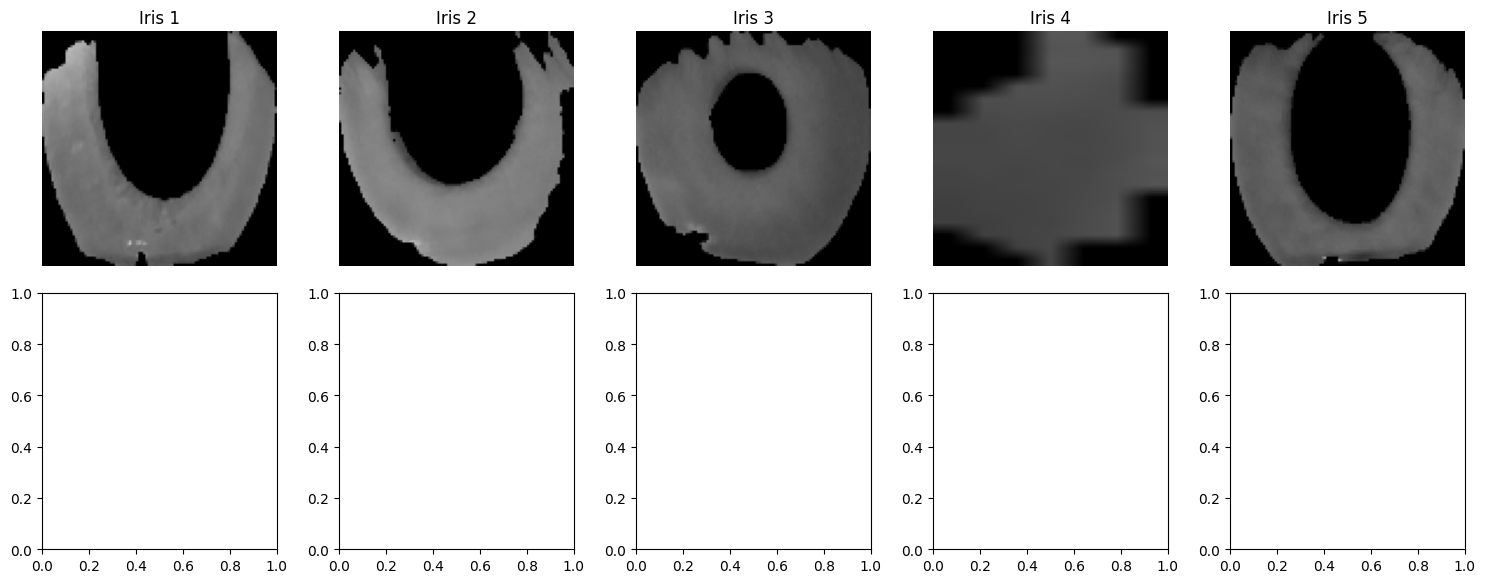

In [3]:

IMG_WIDTH = 100
IMG_HEIGHT = 100


def preprocess_iris_images(image_list, mask_list):
    normalized_images = []
    
    for image, mask in zip(image_list, mask_list):

        masked_image = cv2.bitwise_and(image, image, mask=mask)
        
        # Find contours of the iris region
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            # Get the bounding box of the largest contour (assumed to be the iris region)
            x, y, w, h = cv2.boundingRect(contours[0])
            
            # Crop the iris region
            iris_region = masked_image[y:y+h, x:x+w]
            
            # Resize the cropped iris region to the desired dimensions
            resized_iris = cv2.resize(iris_region, (IMG_WIDTH, IMG_HEIGHT))
            
            # Normalize pixel values to range [0, 1]
            normalized_iris = resized_iris / 255.0
            
            normalized_images.append(normalized_iris)
    
    return normalized_images

# Preprocess iris images
normalized_iris_images = preprocess_iris_images(image_list, mask_list)

# Convert to numpy array
normalized_iris_images = np.array(normalized_iris_images)

# Plot normalized iris images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()

for i in range(len(normalized_iris_images)):
    axs[i].imshow(normalized_iris_images[i], cmap='gray')
    axs[i].set_title(f"Iris {i+1}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


# Experiment 8 - Iris Recognition

## Organising Database

In [4]:
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

images_directory = "/kaggle/input/casia-iris-degradation/CASIA-Iris-Degradation-Database/image"

output_directory = "/kaggle/working/iris"
os.makedirs(output_directory, exist_ok=True)

for filename in os.listdir(images_directory):
    if filename.endswith(".png"):
        subject_id = filename[:4]
        subject_directory = os.path.join(output_directory, subject_id)
        os.makedirs(subject_directory, exist_ok=True)
        src = os.path.join(images_directory, filename)
        dst = os.path.join(subject_directory, filename)
        shutil.copy(src, dst)

2024-03-24 16:20:28.581069: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-24 16:20:28.581163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-24 16:20:28.755828: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Iris Recognition System

## Global Vars

In [ ]:
basedir = "/kaggle/working/iris"
input_shape = (64, 64, 3)  
num_classes = len(os.listdir(basedir))  
batch_size = 32

### Data Gen

In [36]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    directory=basedir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    directory=basedir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 29332 images belonging to 255 classes.
Found 7207 images belonging to 255 classes.


### Model Building

In [37]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 255)            │        32,895 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,658,047 (6.32 MB)

 Trainable params: 1,658,047 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

### Callbacks

In [38]:
checkpoint_path = '/kaggle/working/Models/iris_cnn_model_checkpoint.keras'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

### Model Fitting

In [39]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
  3/917 ━━━━━━━━━━━━━━━━━━━━ 1:20 88ms/step - accuracy: 0.0000e+00 - loss: 5.5609 

W0000 00:00:1711299397.059812     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


910/917 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.0177 - loss: 5.3680

W0000 00:00:1711299559.111066     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 4.37134, saving model to /kaggle/working/Models/iris_cnn_model_checkpoint.keras
917/917 ━━━━━━━━━━━━━━━━━━━━ 205s 219ms/step - accuracy: 0.0179 - loss: 5.3654 - val_accuracy: 0.1193 - val_loss: 4.3713
Epoch 2/50
910/917 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.1561 - loss: 4.0020
Epoch 2: val_loss improved from 4.37134 to 0.00000, saving model to /kaggle/working/Models/iris_cnn_model_checkpoint.keras
917/917 ━━━━━━━━━━━━━━━━━━━━ 161s 175ms/step - accuracy: 0.1564 - loss: 4.0000 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/50
910/917 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.3068 - loss: 3.0102
Epoch 3: val_loss did not improve from 0.00000
917/917 ━━━━━━━━━━━━━━━━━━━━ 204s 221ms/step - accuracy: 0.3070 - loss: 3.0091 - val_accuracy: 0.4640 - val_loss: 2.4200
Epoch 4/50
910/917 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.4181 - loss: 2.4044
Epoch 4: val_loss did not improve from 0.00000
917/917 ━━━━━━━━━━━━━━━━━━━━

## Eval

In [40]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}, Validation Accuracy: {accuracy}')

model.load_weights(checkpoint_path)

final_model_path = '/kaggle/working/Models/iris_cnn_model_final.keras'
model.save(final_model_path)

226/226 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.6776 - loss: 1.3139
Validation Loss: 1.298474907875061, Validation Accuracy: 0.6785070300102234


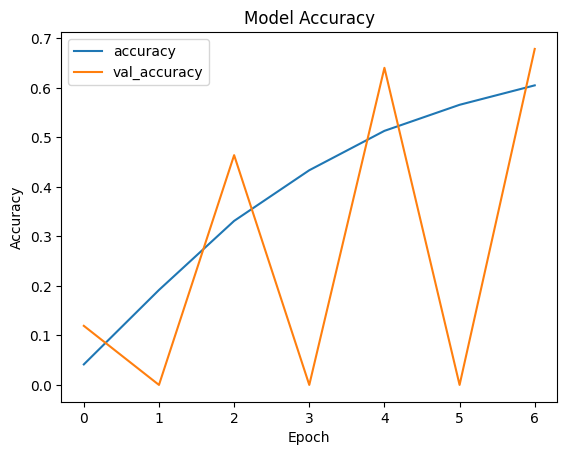

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

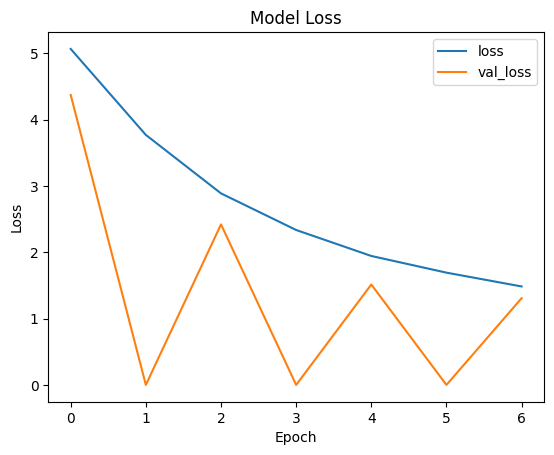

In [42]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()